In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

In [3]:
drive_zip = '/content/drive/My Drive/Colab_Data/vaihingen-trial-data.zip'
zip_ref = zipfile.ZipFile(drive_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [7]:
train_dir = '/tmp/vaihingen-trial-data/'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
image_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(512,512),
                                              batch_size=2,
                                              classes=['image'],
                                              class_mode=None,
                                              seed=1)
label_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(512,512),
                                              batch_size=2,
                                              classes=['label'],
                                              class_mode=None,
                                              seed=1)
train_generator = zip(image_generator,label_generator)





Found 12 images belonging to 1 classes.
Found 12 images belonging to 1 classes.


In [8]:
num_class = 6
def generator():
  for (img,mask) in train_generator:
      new_mask = mask[:,:,:,0]
      new_mask = np.zeros(new_mask.shape+(num_class,))
      c0 = np.stack([mask[...,0]==1,mask[...,1]==1,mask[...,2]==1],axis=-1)
      new_mask[c0.all(-1),0] = 1
      c1 = np.stack([mask[...,0]==0,mask[...,1]==0,mask[...,2]==1],axis=-1)
      new_mask[c1.all(-1),1] = 1
      c2 = np.stack([mask[...,0]==0,mask[...,1]==1,mask[...,2]==1],axis=-1)
      new_mask[c2.all(-1),2] = 1
      c3 = np.stack([mask[...,0]==0,mask[...,1]==1,mask[...,2]==0],axis=-1)
      new_mask[c3.all(-1),3] = 1
      c4 = np.stack([mask[...,0]==1,mask[...,1]==1,mask[...,2]==0],axis=-1)
      new_mask[c4.all(-1),4] = 1
      c5 = np.stack([mask[...,0]==1,mask[...,1]==0,mask[...,2]==0],axis=-1)
      new_mask[c5.all(-1),5] = 1
      #new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3]))
      mask = new_mask
      yield(img,mask)

#mygenerator = generator()
train_dataset = tf.data.Dataset.from_generator(generator,output_types=(tf.float32,tf.int32))
train_generator2 = generator()

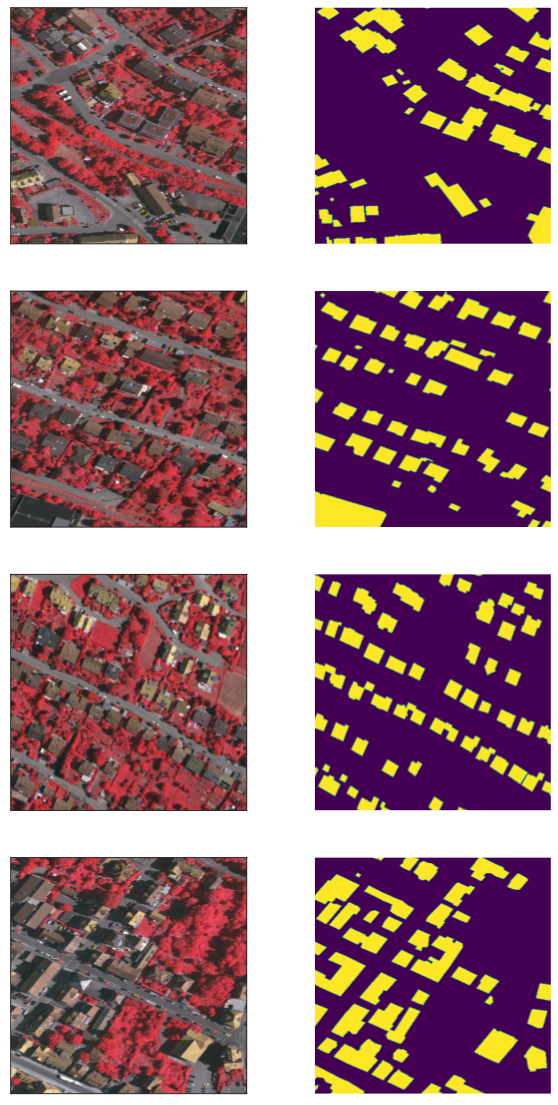

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(10,20)) 
for i,(img,label) in enumerate(train_dataset.unbatch().take(4)):
    ax=plt.subplot(4,2,2*i+1)
    ax.imshow(img)
    #b = tf.reshape(label,[256,256,6])
    bb = label[:,:,1]
    bx=plt.subplot(4,2,2*i+2)
    bx.imshow(bb)

    ax.set_xticks([])
    ax.set_yticks([]) 
    bx.axis('off')

plt.show()

In [10]:
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=(None,None,3)) # 1*3

conv1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(inputs)
pool1 = tf.keras.layers.MaxPooling2D(2,2,padding='same')(conv1) # 1/2 (each side)
conv2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(2,2,padding='same')(conv2) # 1/4
conv3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(2,2,padding='same')(conv3) # 1/8
conv4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(pool3)
pool4 = tf.keras.layers.MaxPooling2D(2,2,padding='same')(conv4) # 1/16
conv5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(pool4)
pool5 = tf.keras.layers.MaxPooling2D(2,2,padding='same')(conv5) # 1/32
pool5 = tf.keras.layers.BatchNormalization()(pool5)

conv6 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(pool5) # 1/32
conv7 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(conv6) # 1/32
conv7 = tf.keras.layers.BatchNormalization()(conv7)

convT1 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(4,4),padding='same')(conv7) # 1/8
convT2 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(pool4) # 1/8
decoder1 = tf.keras.layers.Add()([pool3,convT2,convT1]) # 1/8
decoder2 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(8,8),padding='same')(decoder1) # 1

outputs = tf.keras.layers.Conv2D(6,(1,1),activation='softmax')(decoder2) # 1*6

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 1 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 4640        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
history = model.fit(train_generator2,epochs=50,steps_per_epoch=10)

Epoch 1/50
10/10 [==============================] - 5s 536ms/step - loss: 1.7689 - accuracy: 0.3142
Epoch 2/50
10/10 [==============================] - 6s 596ms/step - loss: 1.7203 - accuracy: 0.3076
Epoch 3/50
10/10 [==============================] - 6s 606ms/step - loss: 1.6850 - accuracy: 0.2937
Epoch 4/50
10/10 [==============================] - 6s 584ms/step - loss: 1.6392 - accuracy: 0.3205
Epoch 5/50
10/10 [==============================] - 6s 595ms/step - loss: 1.5986 - accuracy: 0.3119
Epoch 6/50
10/10 [==============================] - 6s 612ms/step - loss: 1.5580 - accuracy: 0.3186
Epoch 7/50
10/10 [==============================] - 6s 591ms/step - loss: 1.5195 - accuracy: 0.3221
Epoch 8/50
10/10 [==============================] - 6s 592ms/step - loss: 1.4870 - accuracy: 0.3194
Epoch 9/50
10/10 [==============================] - 6s 582ms/step - loss: 1.4641 - accuracy: 0.3329
Epoch 10/50
10/10 [==============================] - 6s 613ms/step - loss: 1.4520 - accuracy: 0.3143

[[1.         1.         0.35102448 ... 0.35102448 0.35102448 0.35102448]
 [1.         1.         0.35102448 ... 0.35102448 0.35102448 0.35102448]
 [0.35102448 0.35102448 0.35102448 ... 0.35102448 0.35102448 0.35102448]
 ...
 [0.35102448 0.35102448 0.35102448 ... 0.35102448 0.35102448 0.35102448]
 [0.35102448 0.35102448 0.35102448 ... 0.35102448 0.35102448 0.35102448]
 [0.35102448 0.35102448 0.35102448 ... 0.35102448 0.35102448 0.35102448]]


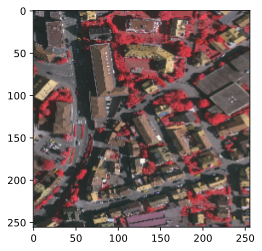

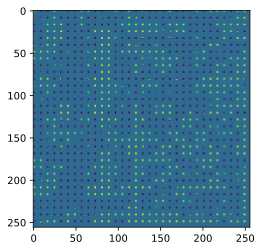

In [113]:
test_path = '/tmp/top_mosaic_09cm_area1.png'
test_img = tf.keras.preprocessing.image.load_img(test_path,target_size=(256,256))
x = tf.keras.preprocessing.image.img_to_array(test_img)

x = np.expand_dims(x,axis=0)
#print(x[0])
pred = model.predict(x)
#plt.imshow(pred[0][...,1])
plt.figure()
plt.imshow(test_img)
plt.figure()
plt.imshow(pred[0][...,1])
print(pred[0][...,1])